# Introduction

Heart disease can lead to fatal heart attacks, so must be treated seriously. In this project, we will analyze past data of patients to try to predict heart disease in a person, with the person’s given medical records.

Our data set comes from the “Heart Disease Data Set” from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. This data set has attributes of patient's medical history and whether or not they have heart disease. We will be using the processed.cleveland.data data set to answer the question:

Is it possible to use existing patient chart data with different attributes of the patient to predict the likelihood of a new patient having heart disease with the help of a classification model?

In [1]:
### Run the R libraries 
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10) #This can only show 10 rows of the dataframe.


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names= FALSE)
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "disease_type")
cleveland_data <- mutate(cleveland_data, disease_type = as_factor(disease_type), thal = as.numeric(thal), ca = as.numeric(ca))
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3


### Cleaning the data by using filter() functions:
Our first step is to filter out the missing rows in the *thal* column and "?" in the *ca* column.

In [3]:
filter_cleveland_data <- cleveland_data |>
    filter(thal != "?", ca != "?") |>
    drop_na()

In order to make a valid prediction, we will only look at whether or not patients have heart disease. *disease_type* has 4 values representing the presence of heart disease, so we mutate this column into "No = no heart disease" and "Yes = has heart disease"

In [4]:
new_cleveland_data <- filter_cleveland_data |> mutate(have_heart_disease = ifelse(disease_type == 0, "No", "Yes")) |> 
select(- disease_type)
new_cleveland_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,have_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,No
67,1,4,160,286,0,2,108,1,1.5,2,3,3,Yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,Yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3,No
41,0,2,130,204,0,2,172,0,1.4,1,0,3,No
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,140,241,0,0,123,1,0.2,2,0,7,Yes
45,1,1,110,264,0,0,132,0,1.2,2,0,7,Yes
68,1,4,144,193,1,0,141,0,3.4,2,2,7,Yes


### Counting the number of people that dont and do have heart disease

In [5]:
heart_dataSet_numbers <- new_cleveland_data |> group_by(have_heart_disease) |> 
summarize(count = n())

heart_dataSet_numbers

have_heart_disease,count
<chr>,<int>
No,160
Yes,137


The table above shows the presence of heart disease in patients from the new_cleveland_data, it shows that 160 people dont have heart disease (have_heart_disease == "No") and 137 people have heart disease (have_heart_disease == "Yes").

# Method

**Data analysis** - Prepare and ready our data set

**Selecting our predicting values** - We used forward selection on all variables to choose the variables which will predict results with most accuracy.

**Visualizing** - We visualize our selected variables with the target variable to confirm there is a strong relation between both.

**Splitting our dataset** - We split our data into training data set and testing data set 


**Building our classification model**

# Visulizations

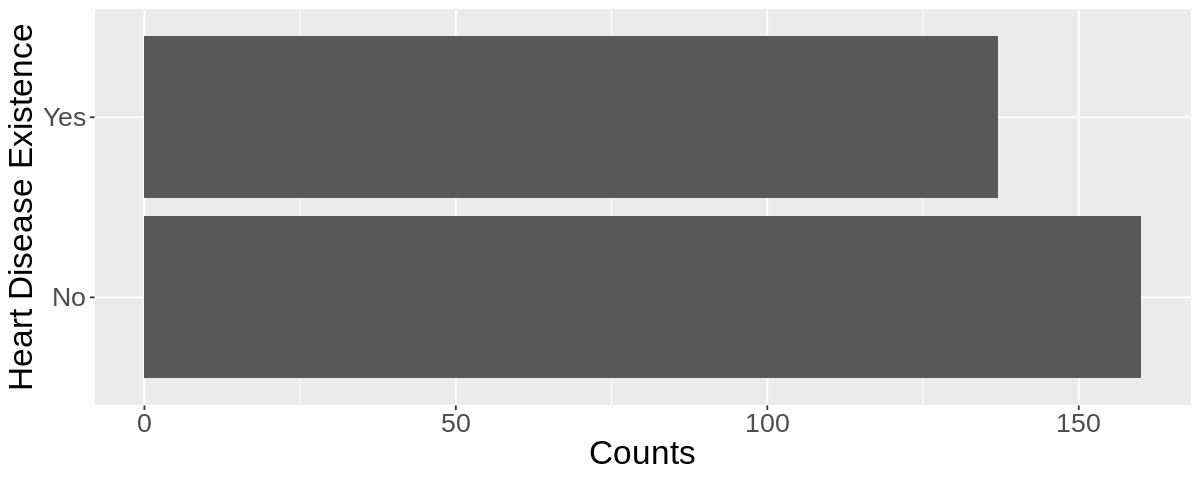

In [6]:
options(repr.plot.width = 10, repr.plot.height = 4)

counting_types <- new_cleveland_data |>
    group_by(have_heart_disease)|>
    summarize(types_count = n()) 

exsitance_plot<- counting_types |>
ggplot(aes( x = have_heart_disease,
            y = types_count)) +
    geom_bar(position='stack', stat='identity') +
    scale_fill_manual(values=c('red', 'purple'))+
    coord_flip() +
    labs(x = "Heart Disease Existence", y = "Counts") +
    theme(text = element_text(size = 20))
exsitance_plot

`geom_smooth()` using formula 'y ~ x'



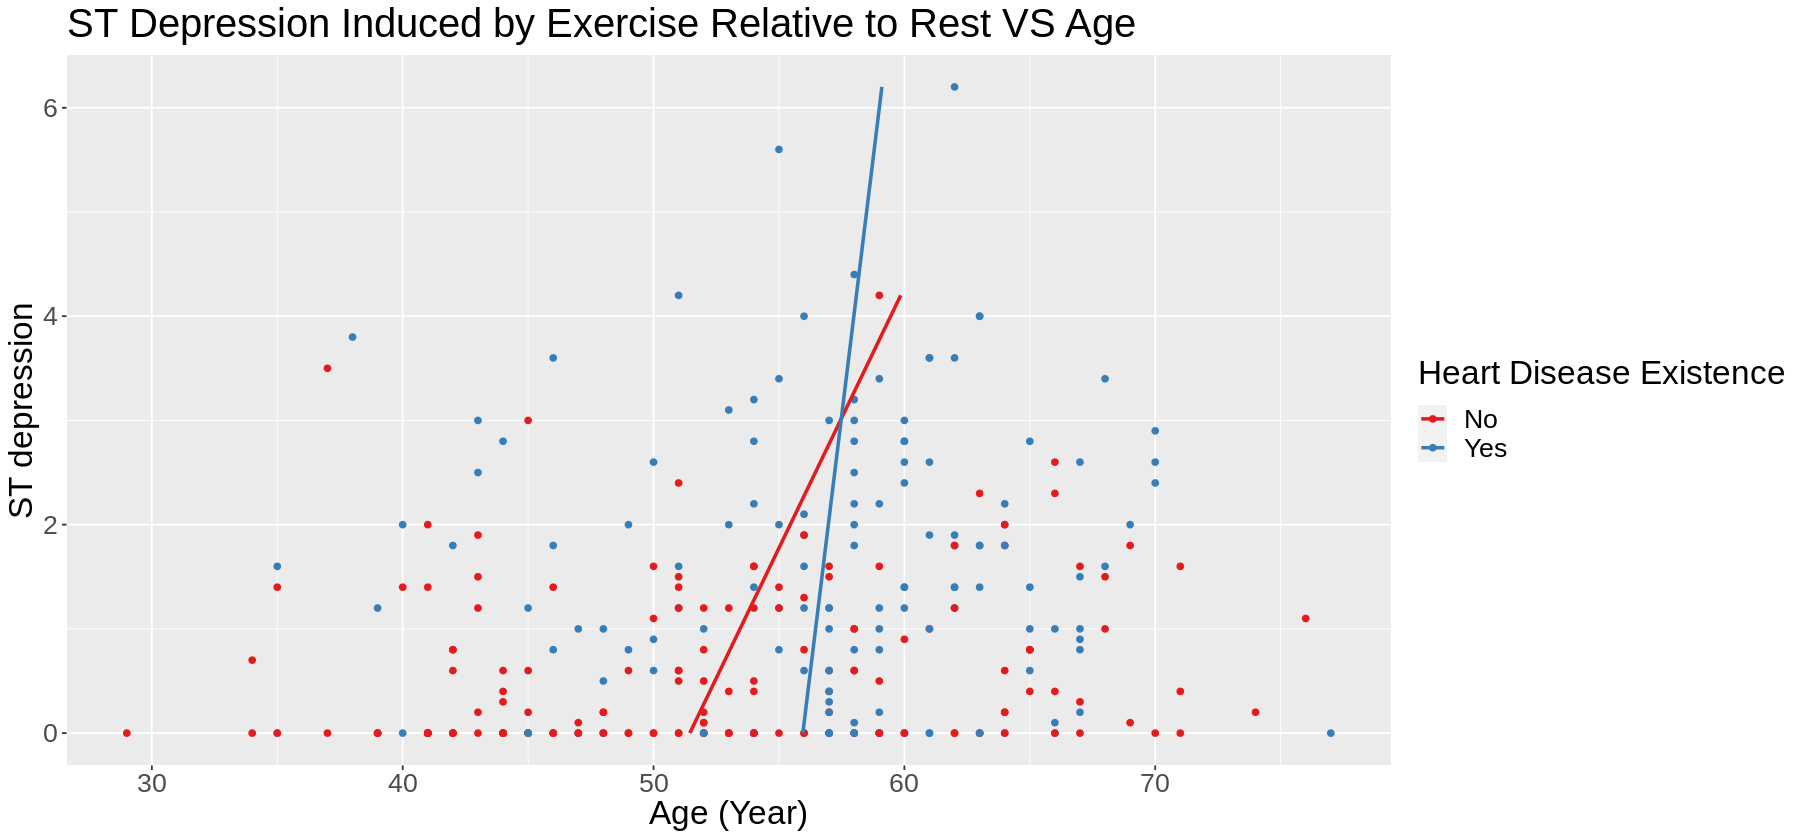

In [7]:
options(repr.plot.width = 15, repr.plot.height = 7)

oldpeak_vs_age<- new_cleveland_data |>
ggplot(aes( x = oldpeak,
            y = age, color= have_heart_disease)) +
    geom_point(stat = 'identity') +
    coord_flip() +
    labs(x = "ST depression", y = "Age (Year)", color = "Heart Disease Existence") +
    theme(text = element_text(size = 20)) +
    geom_smooth(method=lm,se=FALSE)+
    scale_color_brewer(palette="Set1")+
    ggtitle("ST Depression Induced by Exercise Relative to Rest VS Age")
oldpeak_vs_age

In this first plot above, there is a tendency of higher heart disease presence with higher age and higher ST depression.

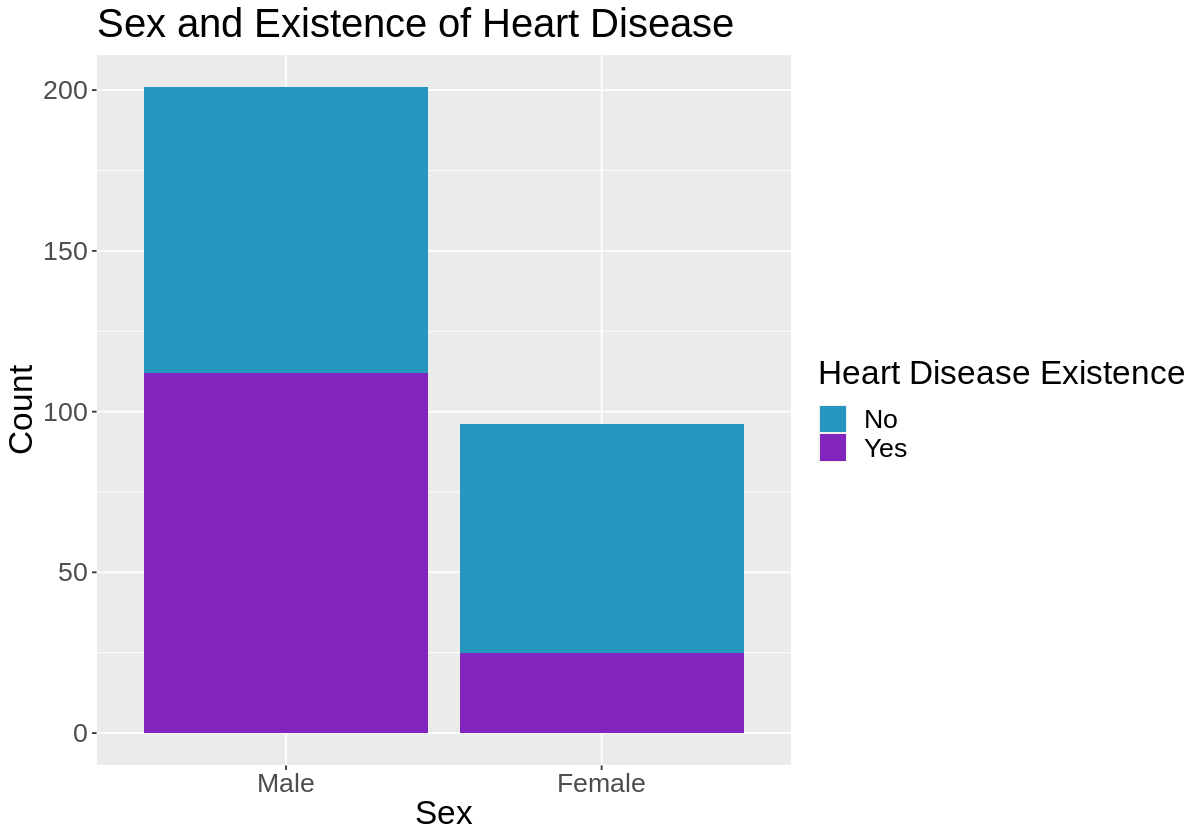

In [8]:
options(repr.plot.width = 10, repr.plot.height = 7)


sex_plot<- new_cleveland_data |>
    mutate(sex = ifelse(sex == 0, "Female", "Male")) |>
    mutate(sex = as_factor(sex)) |>
    ggplot(aes(x = sex, fill = have_heart_disease)) +
    geom_bar() +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Sex", y = "Count", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Sex and Existence of Heart Disease")
sex_plot

In this data set, heart disease is more prevalant in males.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



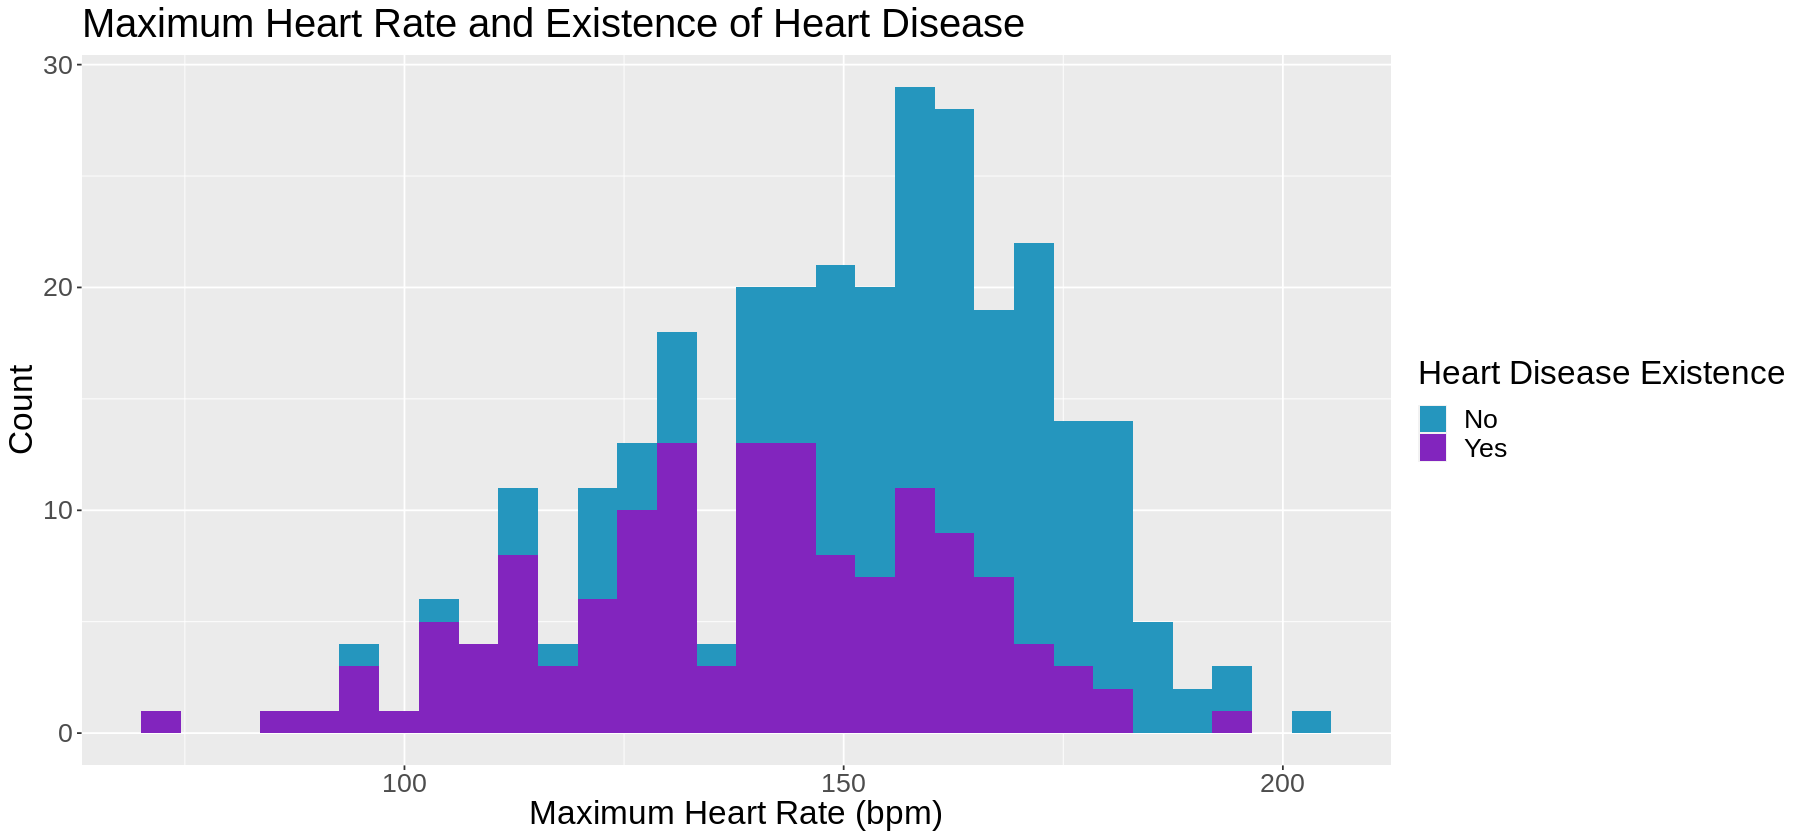

In [9]:
options(repr.plot.width = 15, repr.plot.height = 7)

thalach_plot<- new_cleveland_data |>
ggplot(aes(x = thalach,fill = have_heart_disease)) +
    geom_histogram() +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Maximum Heart Rate (bpm)", y = "Count", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Maximum Heart Rate and Existence of Heart Disease")
thalach_plot

A lower heart rate is more strongly correlated with the presence of heart disease.

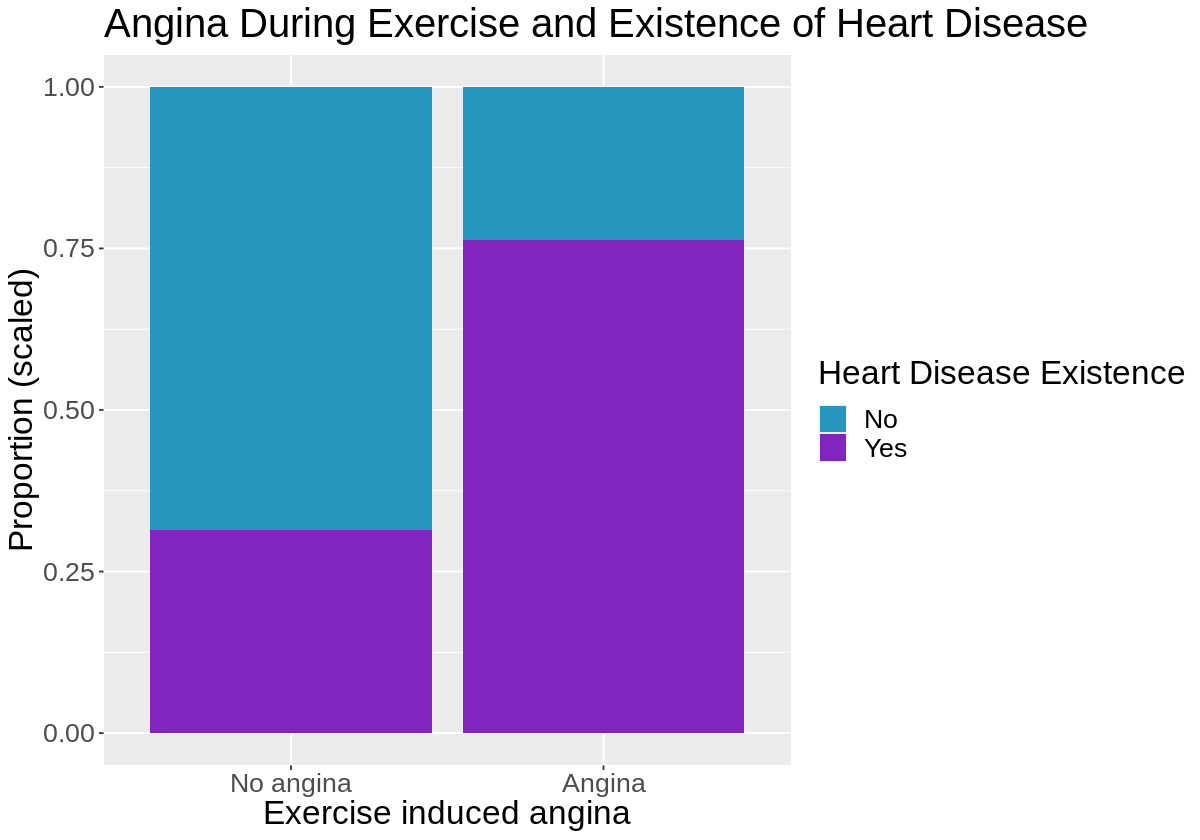

In [26]:
options(repr.plot.width = 10, repr.plot.height = 7)

exang_plot<- new_cleveland_data |>
    mutate(exang = ifelse(exang == 0, "No angina", "Angina")) |>
    mutate(exang = as_factor(exang)) |>
    ggplot(aes(x = exang, fill = have_heart_disease)) +
    geom_bar(position = "fill") +

    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Exercise induced angina", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Angina During Exercise and Existence of Heart Disease")
exang_plot

Patients who experience exercise induced angina have a greater likelihood of developing heart disease.

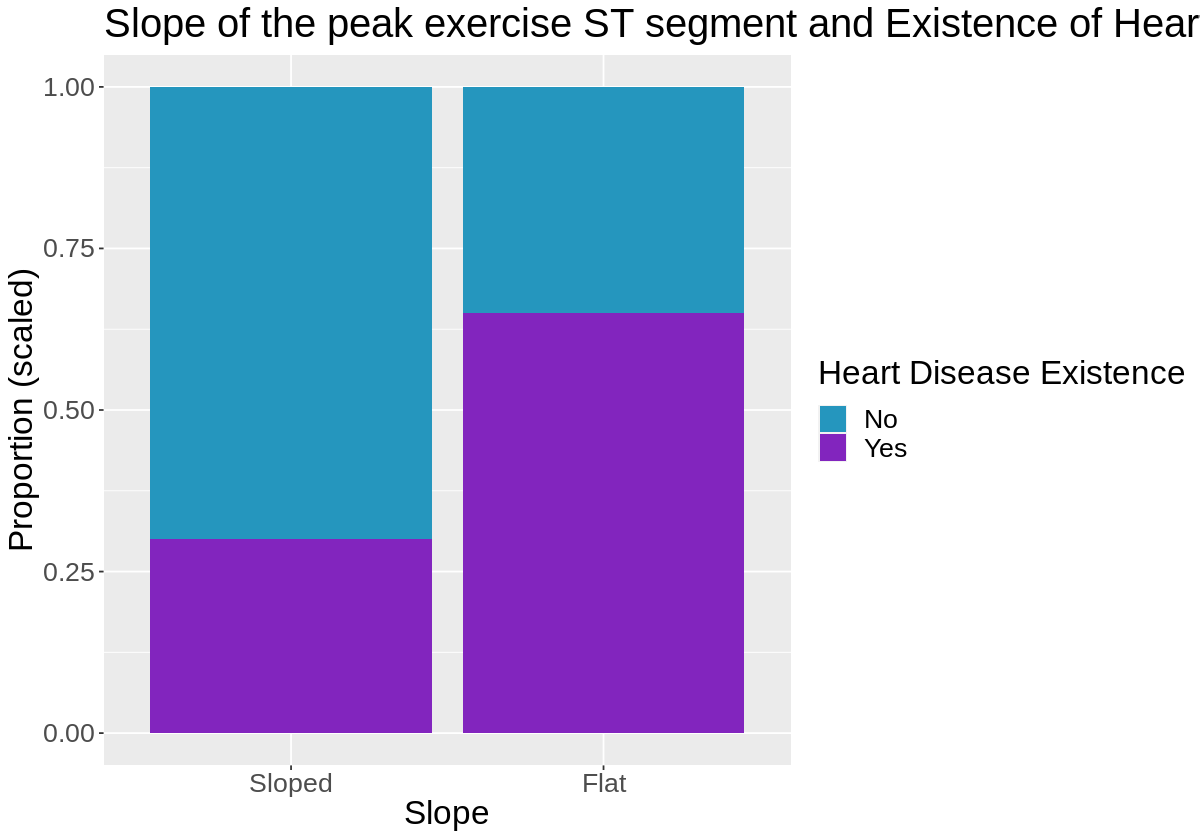

In [27]:
options(repr.plot.width = 10, repr.plot.height = 7)

slope_plot<- new_cleveland_data |>
     mutate(slope = ifelse(slope == 2, "Flat", "Sloped")) |>
    mutate(slope = as_factor(slope)) |>
    ggplot(aes(x = slope, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Slope", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Slope of the peak exercise ST segment and Existence of Heart Disease")
slope_plot

Having a flat slope of the peak exercise ST segment of an electrocardiogram has a higher proportion of heart disease.

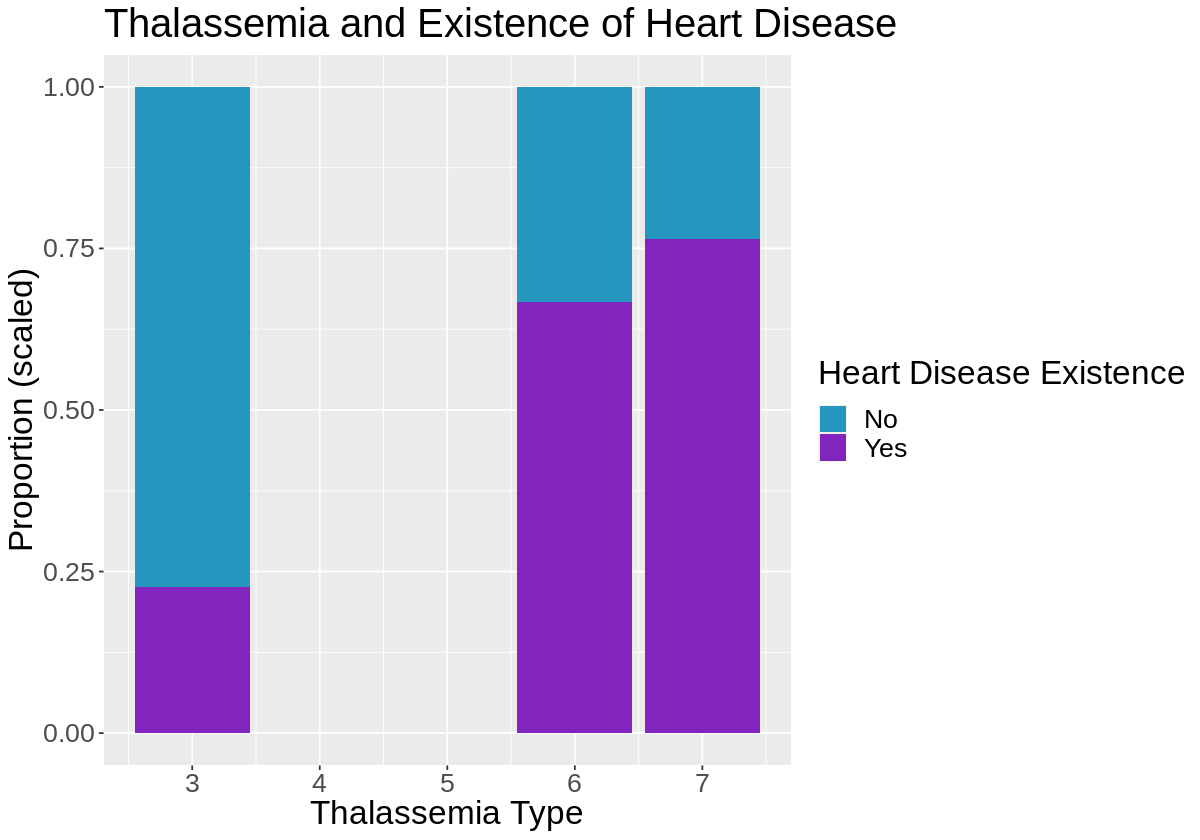

In [28]:
options(repr.plot.width = 10, repr.plot.height = 7)

thal_plot<- new_cleveland_data |>
    ggplot(aes(x = thal, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Thalassemia Type", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Thalassemia and Existence of Heart Disease")
thal_plot

A reversible defect of thalassemia has the highest relative presence of heart disease.

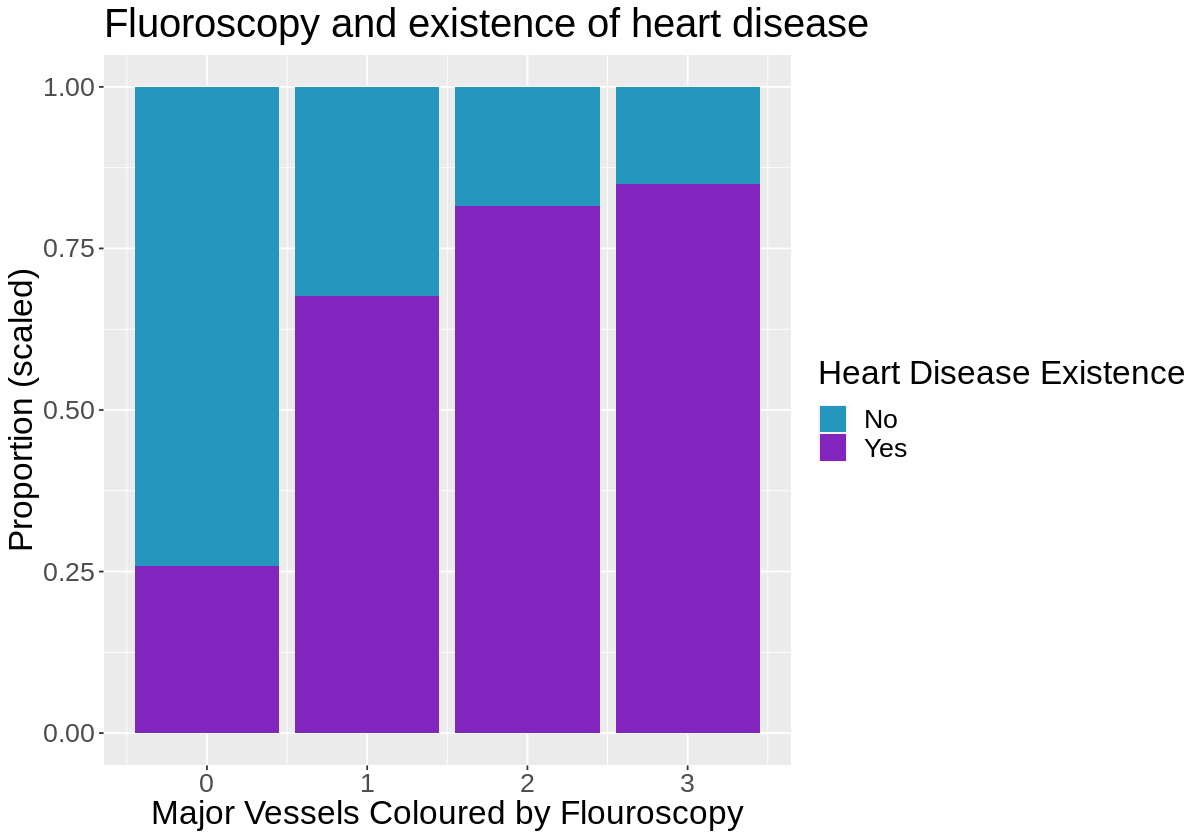

In [29]:
options(repr.plot.width = 10, repr.plot.height = 7)

ca_plot<- new_cleveland_data |>
    ggplot(aes(x = ca, fill = have_heart_disease)) +
    geom_bar(position = "fill") +
    scale_fill_manual(values=c('#2596BE', '#8225BE')) +
    labs(x = "Major Vessels Coloured by Flouroscopy", y = "Proportion (scaled)", fill = "Heart Disease Existence") +
    theme(text = element_text(size = 20))+
    ggtitle("Fluoroscopy and existence of heart disease")
ca_plot

More major vessels coloured by fluoroscopy leads to higher proportions of heart disease.

# Splitting our dataset

After conducting the first data analysis step, we obtained 297 observations that can be utilized for further analysis. Our subsequent step involves dividing the data into two sets, training and test sets. We have decided to use a proportion of 0.75 for training and 0.25 for testing, meaning that 75% of the 297 observations will be assigned to the training set, while the remaining 25% will be placed in a test set. We have set the seed value to 3456 for reference.

In [14]:
# Set the seed.
set.seed(3456) 

# Split the data into 75% and 25%.
data_split <- initial_split(new_cleveland_data, prop = 0.75, strata = have_heart_disease)  

heart_train_set <- training(data_split)   
heart_test_set <- testing(data_split)


# Forward selection

#### use training data for forward selection 

In [15]:
# set.seed(233)

# #select every predictors
# names <- colnames(heart_train_set |> 
# select(age:thal))

# #create a tibble to store the results
# heart_acc <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
#      set_engine("kknn") |>
#      set_mode("classification")

# heart_vfold <- vfold_cv(heart_train_set, v = 5, strata = have_heart_disease)

# n_total <- length(names)

# selected <- c()
     
# #for every size from 1 to the total number of predictors

# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("have_heart_disease", "~", paste(preds_new, collapse="+"))

#         heart_recipe <- recipe(as.formula(model_string), data = heart_train_set) |>
#                           step_scale(all_predictors()) |>
#                           step_center(all_predictors())

     
#         acc <- workflow() |>
#           add_recipe(heart_recipe) |>
#           add_model(knn_spec) |>
#           tune_grid(resamples = heart_vfold, grid = 10) |>
#           collect_metrics() |>
#           filter(.metric == "accuracy") |>
#           summarize(mx = max(mean))
#         acc <- acc$mx |> unlist()

      
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     heart_acc <- heart_acc |> 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }

# print(heart_acc)

<img src="DSCI Forward selection.png" width = "900">

[Table 1.1]

The table [Table1.1] above displays the accuracy of different models after the addition of a new predictor. We observed that the accuracy kept increasing until the 9th predictor been added. This means that we will reach the highest accuracy while having 8 predictors. It is clear from the data that the accuracy of the models increases as more significant variables are incorporated into the model. According to our table, we chose these X variables:

1. 'thalach'
2. 'ca'
3. 'thal'
4. 'exang'
5. 'cp'
6. 'oldpeak'
7. 'age'
8. 'trestbps'

## Building our classification model

### Creating a recipe

To prepare our training data for the classification model, we begin by creating a recipe. We included both the scale and centre functions to make sure that all X predictor variables have a mean of 0 and standard deviation of 1. 

In [16]:
set.seed(3456)

heart_recipe <- recipe(have_heart_disease ~ .,
                       data = heart_train_set) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

### Creating a tuning model

In [17]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn")|>
                set_mode("classification")

In [18]:
k_vals <- tibble(neighbors=seq(from=1, to=20, by=1))

In [19]:
heart_vfold <- vfold_cv(heart_train_set, v = 10, strata = have_heart_disease)

In [20]:
heart_results <- workflow()|>
                add_recipe(heart_recipe)|>
                add_model(knn_spec)|>
                tune_grid(resamples = heart_vfold, grid = k_vals)|>
                collect_metrics()|>
                filter(.metric == "accuracy") 

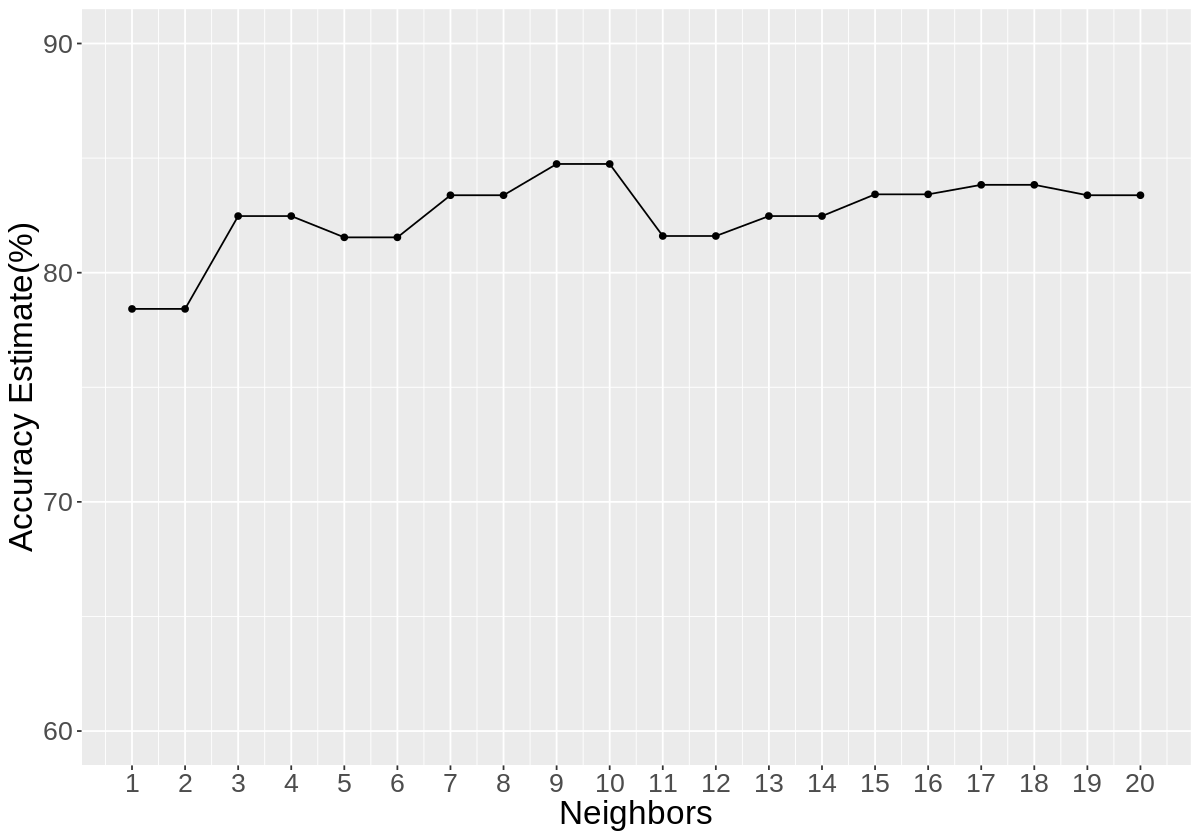

In [21]:
accuracy_plot <- heart_results |>
                ggplot(aes(x = neighbors, y = mean * 100))+
                geom_point()+
                geom_line()+
                labs(x = "Neighbors", y = "Accuracy Estimate(%)")+
                scale_x_continuous(breaks = seq(0, 20, by = 1)) +
                scale_y_continuous(limits = c(60, 90))+
                theme(text = element_text(size = 20))
accuracy_plot

In [22]:
accuracy <- heart_results |> 
      filter(.metric == "accuracy")

In [23]:
best_k <- accuracy |>
          filter(mean == max(mean)) |>        
          select(neighbors)
best_k

best_k_value <- best_k |>
slice(1)|>
pull()

neighbors
<dbl>
9
10


In [24]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_v) |>
              set_engine("kknn") |>
              set_mode("classification")

From the graph above we can observe that using 10 neighbours will give us the highest accuracy for this model. Hence, we wiil use `k = 10` in our k-nn model.

### 